In [46]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/titanic/train.csv")), pd.read_csv(Path("datasets/titanic/test.csv"))

titanic_train, titanic_test = load_titanic_data()
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [47]:
titanic_train = titanic_train.set_index("PassengerId")
titanic_test = titanic_test.set_index("PassengerId")

In [48]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [49]:
titanic_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


array([[<Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>],
       [<Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Fare'}>]], dtype=object)

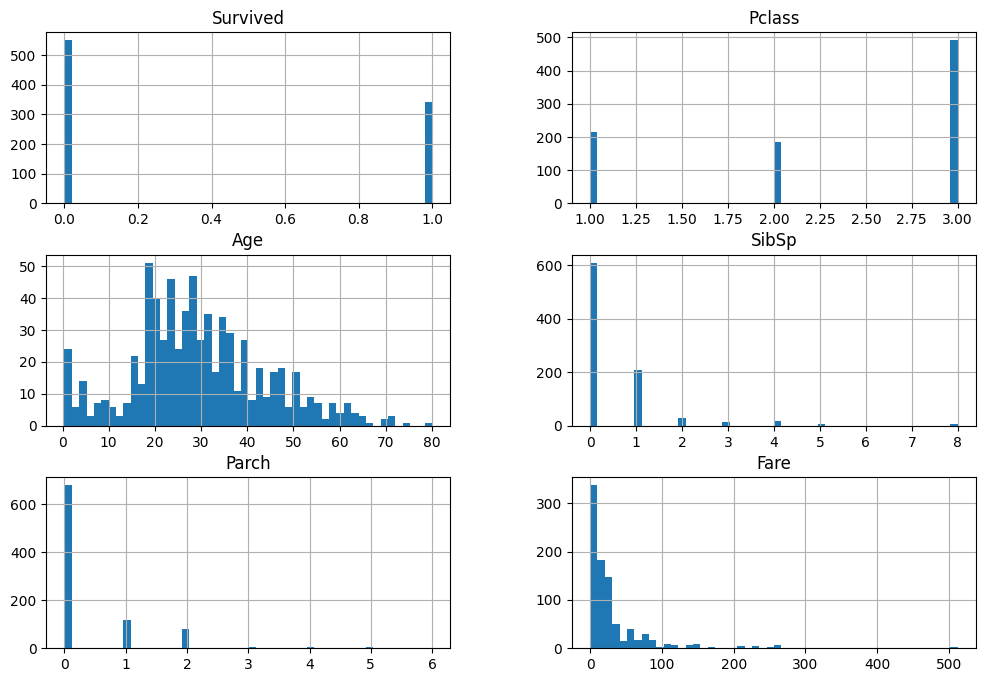

In [50]:
titanic_train.hist(bins=50,figsize=(12,8))

In [51]:
corr_matrix = titanic_train.corr(numeric_only=True)
corr_matrix['Survived'].sort_values(ascending=False)

Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.077221
Pclass     -0.338481
Name: Survived, dtype: float64

In [58]:
titanic_train['AgeRange'] = titanic_train['Age'] // 15 * 15 # categorical age
titanic_train['CabinCategory'] = titanic_train['Cabin'].str[0]
titanic_train['TravellingAlone'] = (titanic_train['SibSp'] + titanic_train['Parch'] == 0)

In [57]:
titanic_train['AgeRange'].value_counts()

AgeRange
15.0    306
30.0    215
45.0     89
0.0      78
60.0     25
75.0      1
Name: count, dtype: int64

In [56]:
titanic_train['CabinCategory'].value_counts()

CabinCategory
C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: count, dtype: int64

In [60]:
titanic_train['TravellingAlone'].value_counts()

TravellingAlone
True     537
False    354
Name: count, dtype: int64

In [59]:
corr_matrix = titanic_train.corr(numeric_only=True)
corr_matrix['Survived'].sort_values(ascending=False)

Survived           1.000000
Fare               0.257307
Parch              0.081629
SibSp             -0.035322
AgeRange          -0.058848
Age               -0.077221
TravellingAlone   -0.203367
Pclass            -0.338481
Name: Survived, dtype: float64

In [ ]:
titanic = titanic_train.drop(["Survived", 'Age', 'SibSp', 'Parch', 'Cabin'], axis=1)
titanic_labels = titanic_train["Survived"].copy()